# Домашнее задание «Модели авторегрессии условной гетероскедантичности»

## **Задание**

1. Выберите ряд из первого задания.
2. Постройте его модель GARCH.
3. Оформите отчёт в Jupyter-ноутбук.

### Выводы:  
Для интереса взял временной ряд Доллар к рублю по закрытию сессии каждый день и отобрал последние 150 дней торговли. Период для анализа из 2023 года.  

Выяснилось, что даже только дифференцирования делает ряд близким к стационарному. БоксКокс особого результата не приносит, что в принципе можно было ожидать по виду ряда.  

Проверил оптимизацией параметров оба метода Arima and GARCH. На выходе получилось примерно одинаково.  

Стационарность портят несколько "выбросов", которые на графике квантилей не попадают на заданную кривую. С другой стороны, "выбросы" совпадают со сменой тренда на графике.



In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from arch import arch_model

In [7]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
def tsplot(y, lags=None, figsize=(14, 12), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [11]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    model = ARIMA(TS, order=(i,d,j))
                    tmp_mdl = model.fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [13]:
def _get_best_model_garch(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    model = arch_model(TS, p=i, o=d, q=j, dist='StudentsT')
                    tmp_mdl = model.fit(update_freq=5, disp='off')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [15]:
USDRUB = pd.read_csv("USDRUB_1D.csv", sep=";")

In [17]:
USDRUB.head()

,TIME,HIGH,LOW,OPEN,CLOSE,VOLUME,VALUE
0,15.04.2003,31.1975,31.185,31.1850,31.1970,36311000.0,1.132583e+09
1,16.04.2003,31.1950,31.185,31.1950,31.1885,23372000.0,7.289744e+08
2,17.04.2003,31.2000,31.170,31.1800,31.1975,60261000.0,1.879374e+09
3,18.04.2003,31.1975,31.180,31.1975,31.1801,33785000.0,1.053497e+09
4,21.04.2003,31.1100,31.100,31.1065,31.1025,16609000.0,5.165712e+08


In [19]:
data = USDRUB.CLOSE[-150:]

Results of Dickey-Fuller Test:
Test Statistic                  -1.354568
p-value                          0.603853
#Lags Used                       1.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


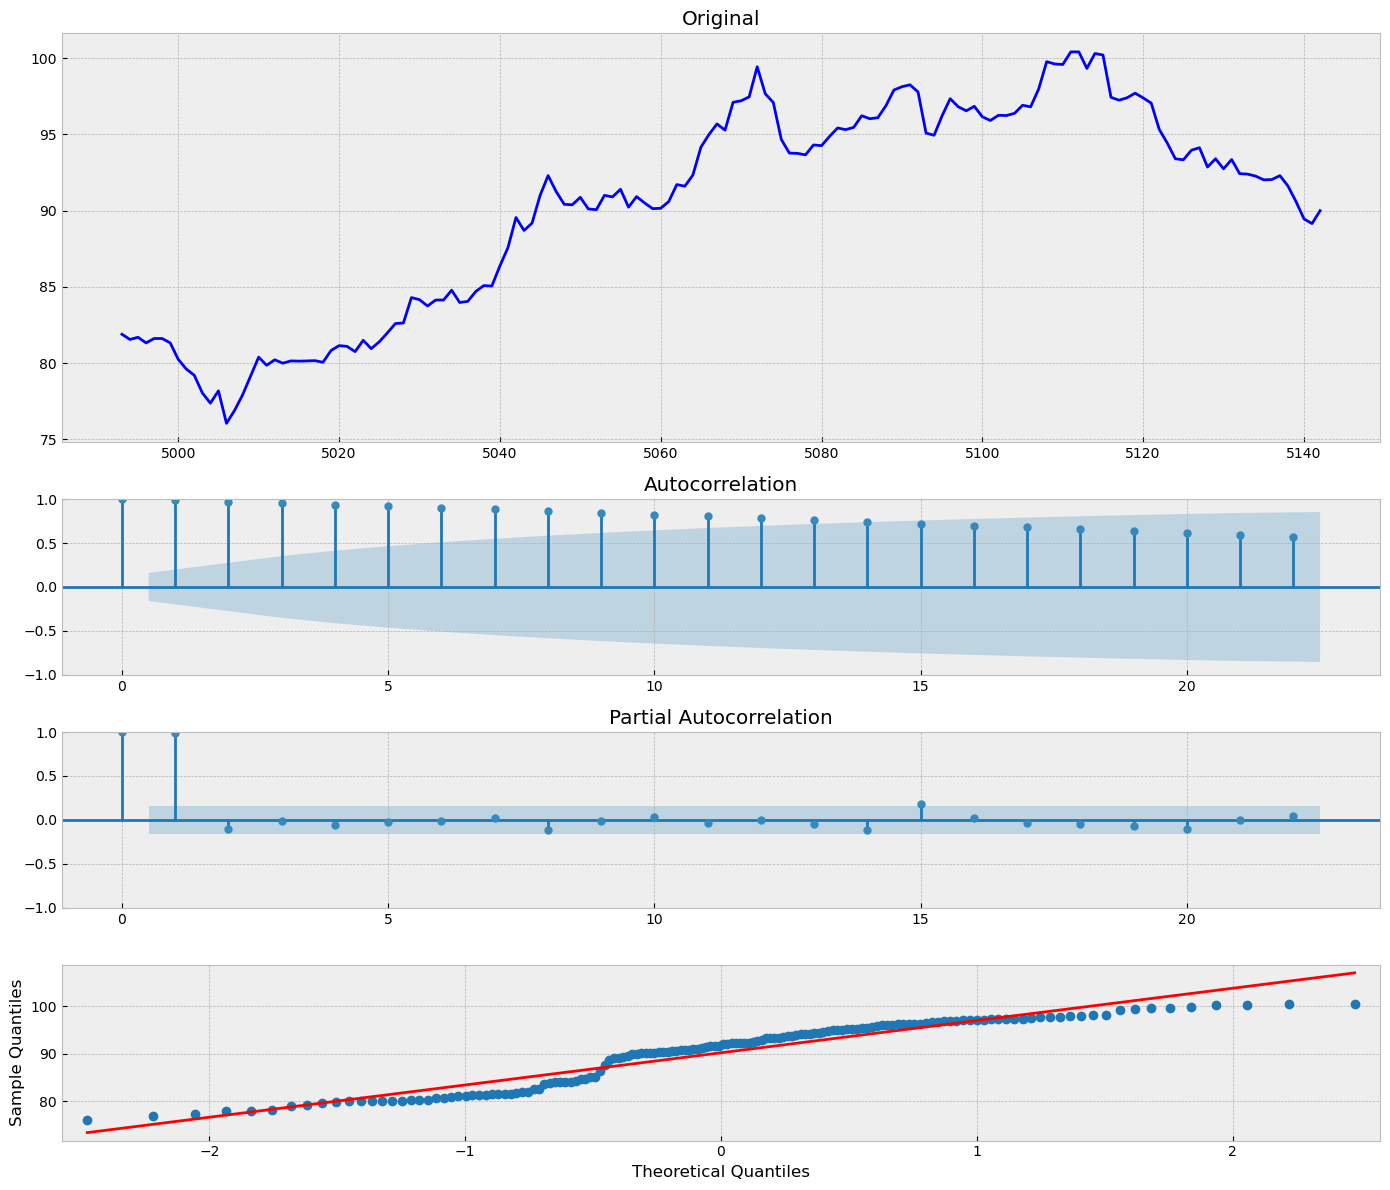

In [21]:
tsplot(data)

In [23]:
data = boxcox(data, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.343072
p-value                          0.609244
#Lags Used                       1.000000
Number of Observations Used    148.000000
Critical Value (1%)             -3.475325
Critical Value (5%)             -2.881275
Critical Value (10%)            -2.577293
dtype: float64


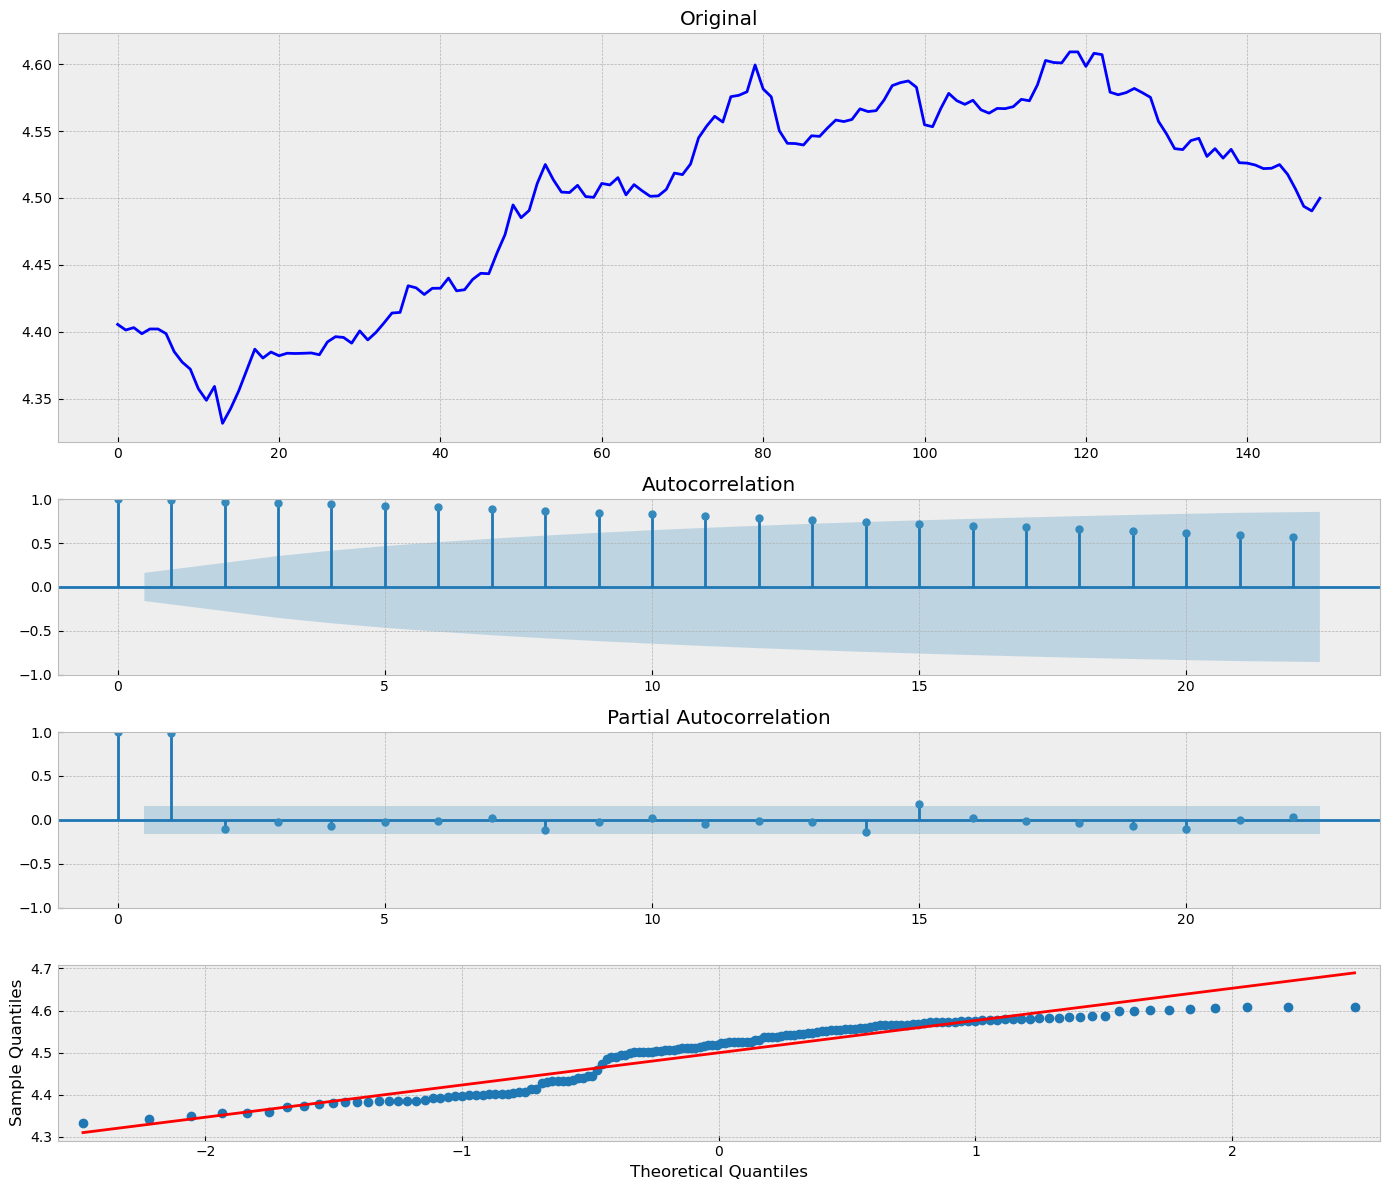

In [25]:
tsplot(data)

In [27]:
data = np.diff(data, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.059270e+01
p-value                        6.466481e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (1%)           -3.475325e+00
Critical Value (5%)           -2.881275e+00
Critical Value (10%)          -2.577293e+00
dtype: float64


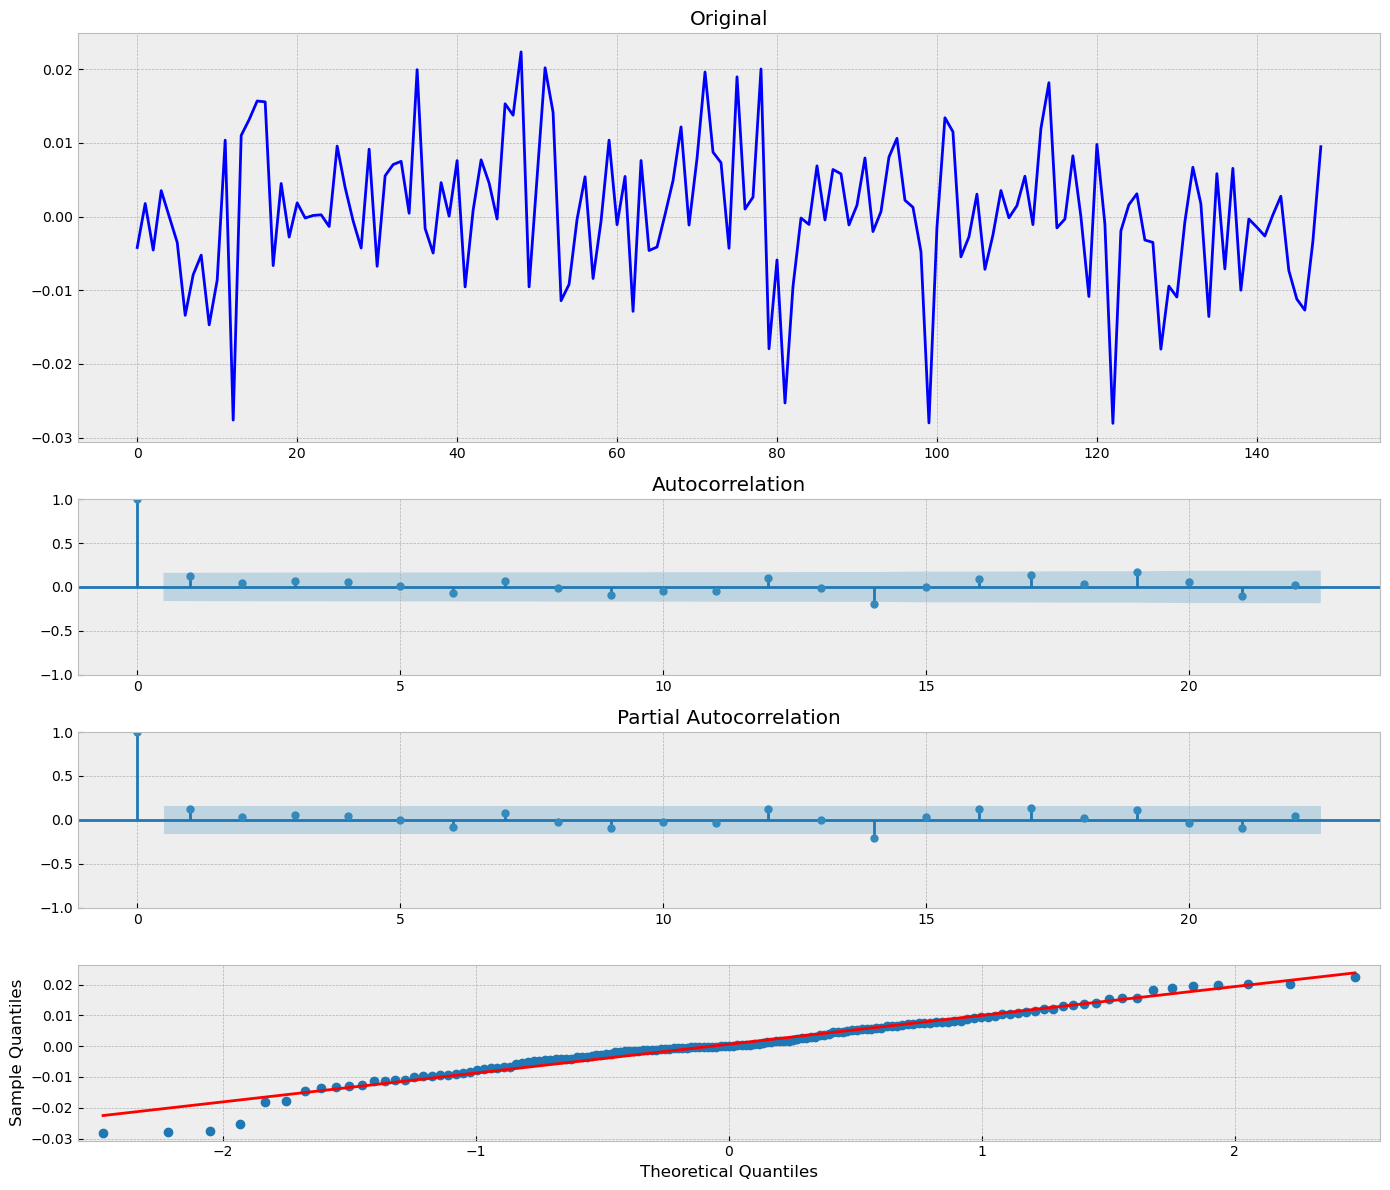

In [29]:
tsplot(data)

In [31]:
aic, order, mdl = _get_best_model(data)

aic: -965.78049 | order: (1, 0, 0)


Results of Dickey-Fuller Test:
Test Statistic                -1.209935e+01
p-value                        2.035380e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (1%)           -3.475325e+00
Critical Value (5%)           -2.881275e+00
Critical Value (10%)          -2.577293e+00
dtype: float64


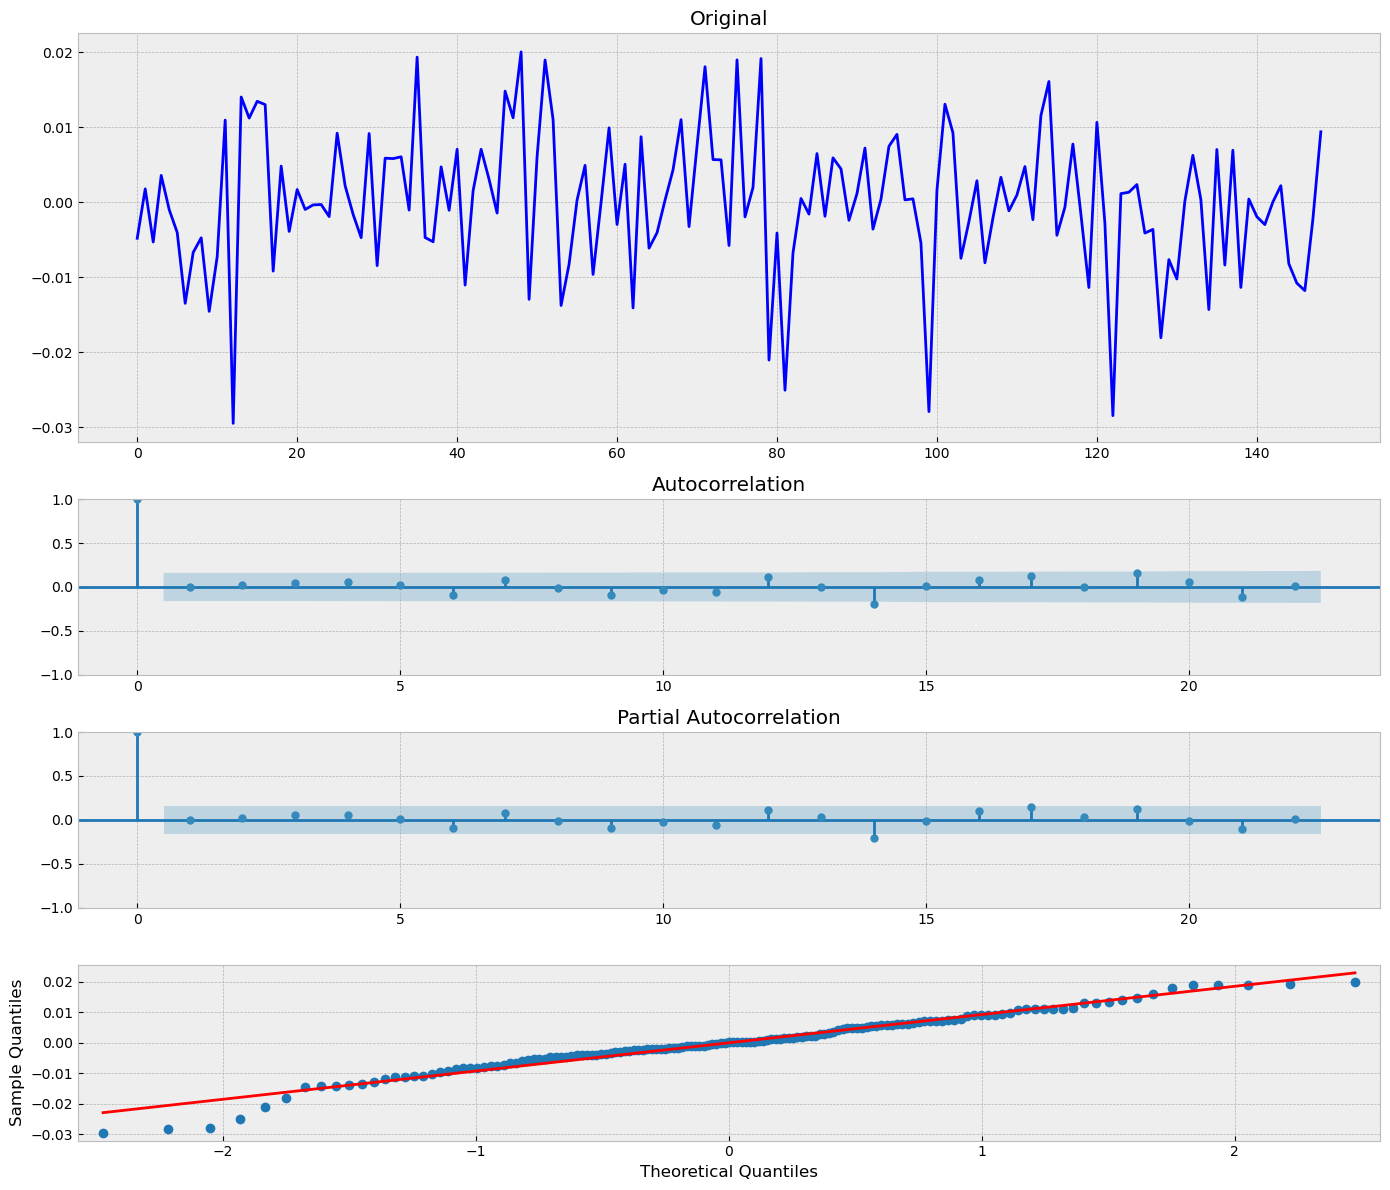

In [32]:
tsplot(mdl.resid)

In [33]:
aic, order, mdl = _get_best_model_garch(data)

C:\Users\grebe\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\grebe\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\grebe\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\grebe\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\grebe

aic: -966.37148 | order: (1, 1, 2)


Results of Dickey-Fuller Test:
Test Statistic                -1.059270e+01
p-value                        6.466481e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.480000e+02
Critical Value (1%)           -3.475325e+00
Critical Value (5%)           -2.881275e+00
Critical Value (10%)          -2.577293e+00
dtype: float64


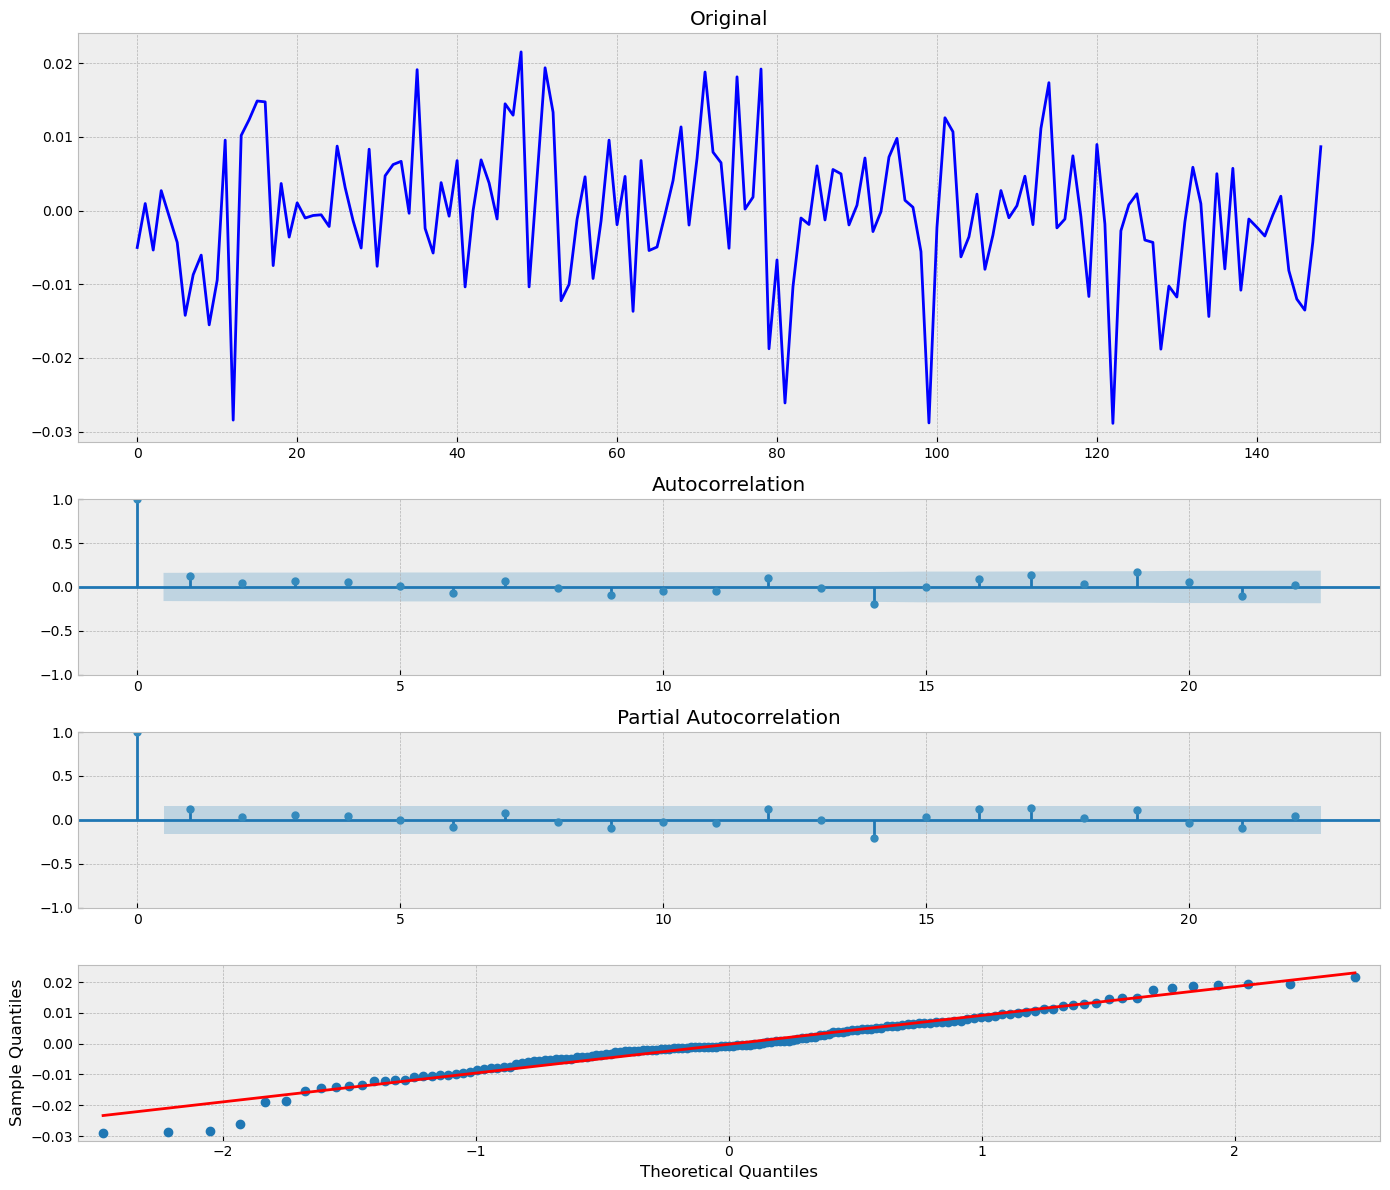

In [34]:
tsplot(mdl.resid)